In [1]:
from main import get_last_data_path
import pickle
from consts import GEMMA_2

data_dir = "data"

data_path = get_last_data_path(data_dir)
with open(data_path, "rb") as f:
    data = pickle.load(f)

c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gemma_2_data = data[GEMMA_2]
position = -1

print(gemma_2_data.keys())

dict_keys(['1161', '1200', '137', '3949', '4086', '4287', '5548', '6832', '695', '709', '7988', '8015'])


In [10]:
import numpy as np

all_vectors, labeling_by_vector, labeling_by_component = [], [], []

for steering_vector, per_vector_data in gemma_2_data.items():
    vec = per_vector_data['meta']['direction']
    all_vectors.append(vec.float())
    labeling_by_vector.append(steering_vector)
    labeling_by_component.append('vector')
    data_at_position = per_vector_data[position]
    negative_outputs_train, positive_outputs_train, negative_outputs_test, positive_outputs_test = data_at_position
    negative_dots_train, negative_norms_train, negative_agg_train = negative_outputs_train
    positive_dots_train, positive_norms_train, positive_agg_train = positive_outputs_train
    for component_name in negative_agg_train.keys():
        diff_means = positive_agg_train[component_name] - negative_agg_train[component_name]
        all_vectors.append(diff_means.float())
        labeling_by_component.append(component_name)
        labeling_by_vector.append(steering_vector)

all_vectors = np.array(all_vectors)
labeling_by_vector = np.array(labeling_by_vector)
labeling_by_component = np.array(labeling_by_component)


In [11]:
_, labeling_by_vector = np.unique(labeling_by_vector, return_inverse=True)
_, labeling_by_component = np.unique(labeling_by_component, return_inverse=True)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification
import umap

print("\nRunning t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, metric='cosine')
X_tsne = tsne.fit_transform(all_vectors)


print("\nRunning UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
X_umap = reducer.fit_transform(all_vectors)



Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Generating plots...


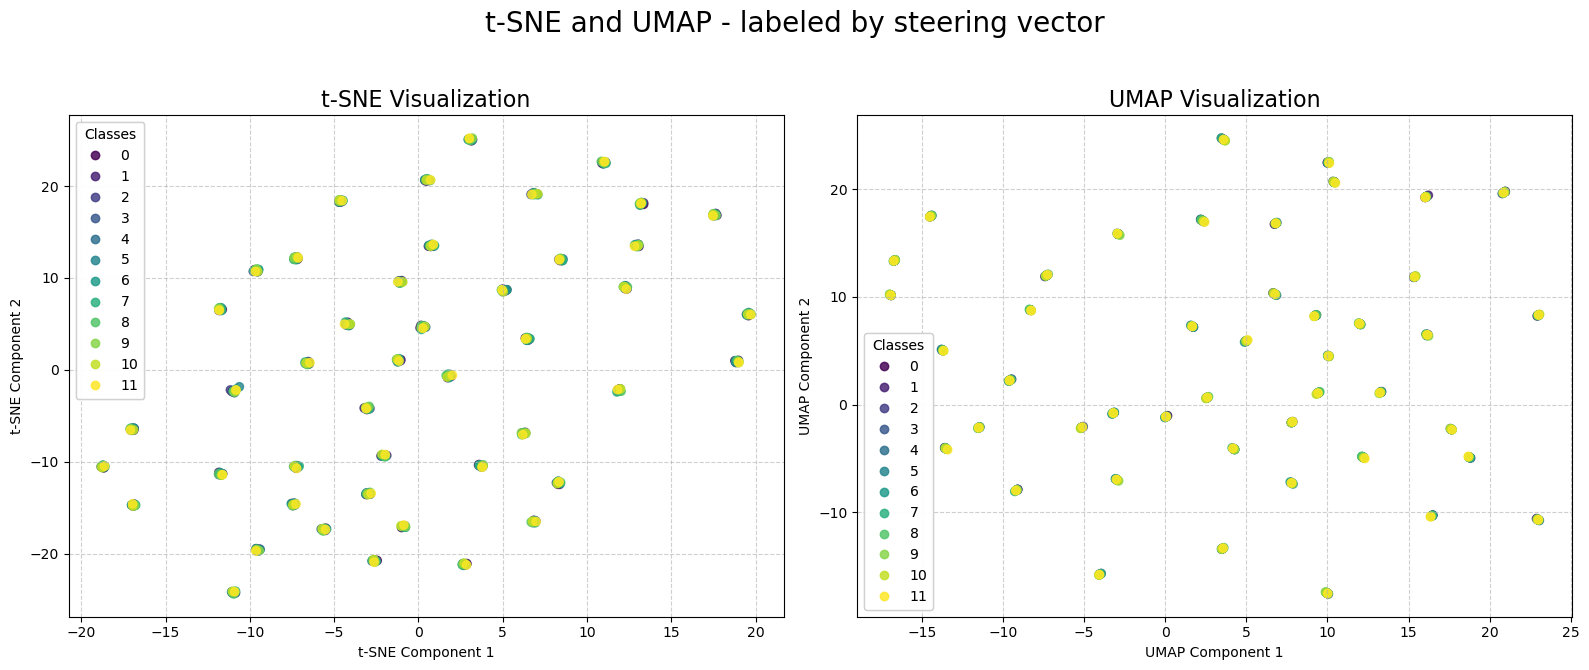

Done.


In [13]:

print("\nGenerating plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))


scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labeling_by_vector, cmap='viridis', alpha=0.8)
ax1.set_title('t-SNE Visualization', fontsize=16)
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.grid(True, linestyle='--', alpha=0.6)
legend1 = ax1.legend(*scatter1.legend_elements(), title="Classes")
ax1.add_artist(legend1)

scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=labeling_by_vector, cmap='viridis', alpha=0.8)
ax2.set_title('UMAP Visualization', fontsize=16)
ax2.set_xlabel('UMAP Component 1')
ax2.set_ylabel('UMAP Component 2')
ax2.grid(True, linestyle='--', alpha=0.6)
legend2 = ax2.legend(*scatter2.legend_elements(), title="Classes")
ax2.add_artist(legend2)

plt.suptitle('t-SNE and UMAP - labeled by steering vector', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("Done.")


Generating plots...


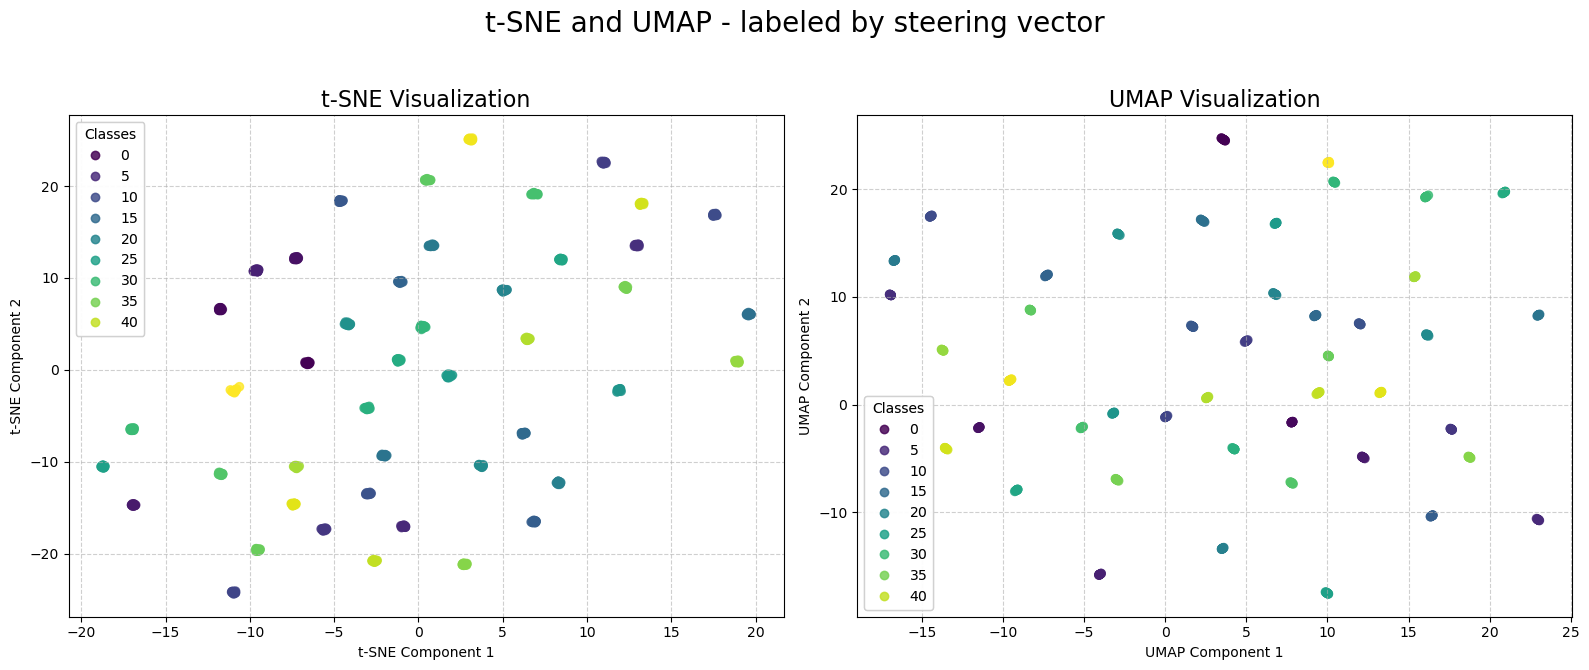

Done.


In [14]:
print("\nGenerating plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))


scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labeling_by_component, cmap='viridis', alpha=0.8)
ax1.set_title('t-SNE Visualization', fontsize=16)
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.grid(True, linestyle='--', alpha=0.6)
legend1 = ax1.legend(*scatter1.legend_elements(), title="Classes")
ax1.add_artist(legend1)

scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=labeling_by_component, cmap='viridis', alpha=0.8)
ax2.set_title('UMAP Visualization', fontsize=16)
ax2.set_xlabel('UMAP Component 1')
ax2.set_ylabel('UMAP Component 2')
ax2.grid(True, linestyle='--', alpha=0.6)
legend2 = ax2.legend(*scatter2.legend_elements(), title="Classes")
ax2.add_artist(legend2)

plt.suptitle('t-SNE and UMAP - labeled by steering vector', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("Done.")

In [9]:
all_vectors.shape

(540, 2304)